In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                        generator=g)

parameters = (C, W1, b1, W2, b2)
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [7]:
# same optimization as previous, just cleaned up
max_steps = 2000000 # ooooooh wee computer death
batch_size = 32
lossi = []
for i in range(max_steps):

    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch of X, Y

    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 1000000 else 0.01 # learning rate step decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i  % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/2000000: 27.8817
  10000/2000000: 2.8263
  20000/2000000: 2.5130
  30000/2000000: 2.8010
  40000/2000000: 2.0541
  50000/2000000: 2.6152
  60000/2000000: 2.3549
  70000/2000000: 2.0835
  80000/2000000: 2.2652
  90000/2000000: 2.2635
 100000/2000000: 2.0810
 110000/2000000: 2.5915
 120000/2000000: 1.9485
 130000/2000000: 2.7237
 140000/2000000: 2.2815
 150000/2000000: 2.2346
 160000/2000000: 1.9754
 170000/2000000: 1.8894
 180000/2000000: 2.3446
 190000/2000000: 1.8712
 200000/2000000: 2.4319
 210000/2000000: 1.9084
 220000/2000000: 2.6478
 230000/2000000: 2.7538
 240000/2000000: 2.3491
 250000/2000000: 2.6973
 260000/2000000: 2.2695
 270000/2000000: 1.8073
 280000/2000000: 2.4758
 290000/2000000: 2.4311
 300000/2000000: 1.9903
 310000/2000000: 2.1573
 320000/2000000: 2.2932
 330000/2000000: 2.4472
 340000/2000000: 2.1652
 350000/2000000: 2.4721
 360000/2000000: 2.3728
 370000/2000000: 2.2591
 380000/2000000: 2.0246
 390000/2000000: 2.2756
 400000/2000000: 2.1373
 410000/2000000

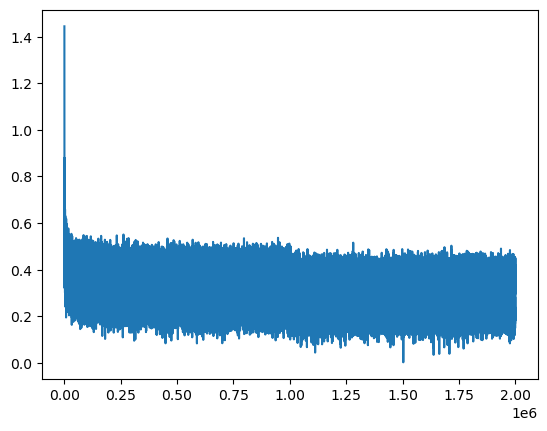

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (n, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat. into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.020451545715332
val 2.1167681217193604


In [11]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(2000):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (1, block_size, n_embd)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distributio
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if sample special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word. 

dexza.
loulyus.
rochi.
ahnee.
jimmana.
nella.
kama.
darro.
zylus.
trer.
gotti.
moriellahu.
keith.
arek.
emia.
sade.
enkavion.
raslyn.
hun.
devatallas.
kasprudi.
jolet.
alaira.
jerrienne.
ezer.
der.
jair.
theoghaj.
hadisabrendi.
saquanna.
briel.
harlen.
xzai.
kalma.
avayah.
luce.
ellasten.
miley.
saheen.
emel.
ille.
lah.
idan.
eziah.
jhonel.
emma.
asha.
franlus.
holin.
chasvi.
selanelle.
kay.
renniairy.
tamira.
dougnui.
righ.
caro.
alla.
kainutha.
marlee.
ayra.
beka.
marinfahea.
adalaykia.
ghon.
daliah.
laklauzo.
ros.
nah.
yel.
naiyanos.
lormer.
declartiebel.
jedshayla.
eron.
marvit.
ricko.
cric.
javiousachena.
raw.
lizingtona.
nef.
mademarosee.
jay.
kawie.
arion.
keita.
summi.
michawn.
razhan.
jon.
sandreydaeghani.
nadenoci.
karu.
juliah.
azemir.
reighanah.
jak.
sakin.
zara.
git.
javersion.
avallin.
souro.
enviran.
madelayden.
aarolynn.
mole.
pris.
jerrit.
paina.
aurelyn.
dari.
consulomari.
keem.
dj.
brilous.
lee.
jerke.
audriko.
tiya.
dyetza.
valei.
urncenzy.
jaisaklynnon.
meen.
trah.